# Method 2 - Best Ideas High Minus Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
low_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

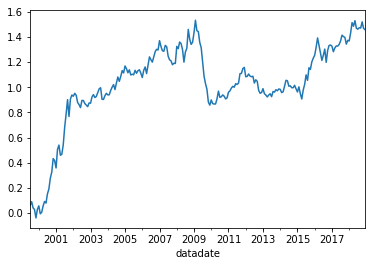

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.028329
2000-12-31    0.377913
2001-12-31    0.368068
2002-12-31   -0.032542
2003-12-31    0.040784
2004-12-31    0.083221
2005-12-31   -0.001170
2006-12-31    0.087483
2007-12-31   -0.046742
2008-12-31    0.077029
2009-12-31   -0.212101
2010-12-31    0.031104
2011-12-31    0.126882
2012-12-31   -0.093081
2013-12-31    0.014720
2014-12-31    0.000711
2015-12-31    0.122526
2016-12-31    0.046931
2017-12-31    0.015925
2018-12-31    0.035947
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     11.12
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.90e-08
Time:                        00:56:35   Log-Likelihood:                 533.02
No. Observations:                 234   AIC:                            -1056.
Df Residuals:                     229   BIC:                            -1039.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.347      0.020       0.001       0.007
mktrf         -0.1176      0.047     -2.515      0.013      -0.210      -0.025
me            -0.0481      0.054     -0.885      0.377      -0.155       0.059
ia             0.3101      0.083      3.751      0.000       0.147       0.473
roe            0.0661      0.071      0.934      0.351      -0.073       0.206
==============================================================================
Omnibus:                       13.328   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.457
Skew:                           0.319   Prob(JB):                     1.33e-05
Kurtosis:                       4.377   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     5.657
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000233
Time:                        00:56:35   Log-Likelihood:                 533.02
No. Observations:                 234   AIC:                            -1056.
Df Residuals:                     229   BIC:                            -1039.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.289      0.022       0.001       0.007
mktrf         -0.1176      0.053     -2.215      0.027      -0.222      -0.014
me            -0.0481      0.061     -0.791      0.429      -0.167       0.071
ia             0.3101      0.119      2.606      0.009       0.077       0.543
roe            0.0661      0.075      0.878      0.380      -0.082       0.214
==============================================================================
Omnibus:                       13.328   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.457
Skew:                           0.319   Prob(JB):                     1.33e-05
Kurtosis:                       4.377   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     4.894
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000835
Time:                        00:56:35   Log-Likelihood:                 533.02
No. Observations:                 234   AIC:                            -1056.
Df Residuals:                     229   BIC:                            -1039.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.213      0.027       0.000       0.008
mktrf         -0.1176      0.051     -2.296      0.022      -0.218      -0.017
me            -0.0481      0.054     -0.893      0.372      -0.154       0.057
ia             0.3101      0.130      2.381      0.017       0.055       0.565
roe            0.0661      0.076      0.865      0.387      -0.084       0.216
==============================================================================
Omnibus:                       13.328   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.457
Skew:                           0.319   Prob(JB):                     1.33e-05
Kurtosis:                       4.377   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     11.31
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.31e-10
Time:                        00:56:35   Log-Likelihood:                 538.16
No. Observations:                 234   AIC:                            -1064.
Df Residuals:                     228   BIC:                            -1044.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.193      0.029       0.000       0.007
mktrf         -0.1116      0.046     -2.430      0.016      -0.202      -0.021
smb           -0.0409      0.061     -0.674      0.501      -0.160       0.079
hml            0.1680      0.071      2.350      0.020       0.027       0.309
rmw            0.1270      0.081      1.571      0.118      -0.032       0.286
cma            0.0909      0.103      0.885      0.377      -0.111       0.293
==============================================================================
Omnibus:                       13.573   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.250
Skew:                           0.301   Prob(JB):                     5.42e-06
Kurtosis:                       4.457   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     7.514
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-06
Time:                        00:56:35   Log-Likelihood:                 538.16
No. Observations:                 234   AIC:                            -1064.
Df Residuals:                     228   BIC:                            -1044.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.193      0.028       0.000       0.007
mktrf         -0.1116      0.047     -2.370      0.018      -0.204      -0.019
smb           -0.0409      0.075     -0.547      0.585      -0.187       0.106
hml            0.1680      0.098      1.711      0.087      -0.024       0.360
rmw            0.1270      0.106      1.193      0.233      -0.082       0.335
cma            0.0909      0.108      0.843      0.399      -0.120       0.302
==============================================================================
Omnibus:                       13.573   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.250
Skew:                           0.301   Prob(JB):                     5.42e-06
Kurtosis:                       4.457   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     7.361
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.04e-06
Time:                        00:56:35   Log-Likelihood:                 538.16
No. Observations:                 234   AIC:                            -1064.
Df Residuals:                     228   BIC:                            -1044.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.346      0.019       0.001       0.007
mktrf         -0.1116      0.051     -2.198      0.028      -0.211      -0.012
smb           -0.0409      0.070     -0.582      0.560      -0.178       0.097
hml            0.1680      0.084      1.994      0.046       0.003       0.333
rmw            0.1270      0.088      1.437      0.151      -0.046       0.300
cma            0.0909      0.104      0.876      0.381      -0.112       0.294
==============================================================================
Omnibus:                       13.573   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               24.250
Skew:                           0.301   Prob(JB):                     5.42e-06
Kurtosis:                       4.457   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     14.00
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.12e-10
Time:                        00:56:35   Log-Likelihood:                 537.83
No. Observations:                 234   AIC:                            -1066.
Df Residuals:                     229   BIC:                            -1048.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.670      0.008       0.001       0.008
mktrf         -0.1314      0.042     -3.116      0.002      -0.215      -0.048
smb           -0.1048      0.053     -1.991      0.048      -0.209      -0.001
hml            0.2410      0.052      4.608      0.000       0.138       0.344
umd            0.0444      0.034      1.293      0.197      -0.023       0.112
==============================================================================
Omnibus:                        9.114   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               13.224
Skew:                           0.246   Prob(JB):                      0.00134
Kurtosis:                       4.056   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     9.151
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.10e-07
Time:                        00:56:35   Log-Likelihood:                 537.83
No. Observations:                 234   AIC:                            -1066.
Df Residuals:                     229   BIC:                            -1048.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.735      0.006       0.001       0.008
mktrf         -0.1314      0.056     -2.367      0.018      -0.240      -0.023
smb           -0.1048      0.049     -2.147      0.032      -0.201      -0.009
hml            0.2410      0.094      2.551      0.011       0.056       0.426
umd            0.0444      0.051      0.865      0.387      -0.056       0.145
==============================================================================
Omnibus:                        9.114   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               13.224
Skew:                           0.246   Prob(JB):                      0.00134
Kurtosis:                       4.056   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     8.720
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.44e-06
Time:                        00:56:35   Log-Likelihood:                 537.83
No. Observations:                 234   AIC:                            -1066.
Df Residuals:                     229   BIC:                            -1048.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.817      0.005       0.001       0.007
mktrf         -0.1314      0.057     -2.304      0.021      -0.243      -0.020
smb           -0.1048      0.051     -2.043      0.041      -0.205      -0.004
hml            0.2410      0.099      2.426      0.015       0.046       0.436
umd            0.0444      0.053      0.837      0.403      -0.060       0.148
==============================================================================
Omnibus:                        9.114   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               13.224
Skew:                           0.246   Prob(JB):                      0.00134
Kurtosis:                       4.056   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     9.770
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.72e-07
Time:                        00:56:35   Log-Likelihood:                 259.99
No. Observations:                 120   AIC:                            -510.0
Df Residuals:                     115   BIC:                            -496.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.003      2.432      0.017       0.001       0.012
mktrf         -0.1221      0.073     -1.673      0.097      -0.267       0.022
me            -0.1106      0.072     -1.535      0.128      -0.253       0.032
ia             0.5113      0.113      4.529      0.000       0.288       0.735
roe           -0.0510      0.100     -0.510      0.611      -0.249       0.147
==============================================================================
Omnibus:                       10.319   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.714
Skew:                           0.501   Prob(JB):                      0.00173
Kurtosis:                       4.240   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     11.17
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.08e-07
Time:                        00:56:35   Log-Likelihood:                 259.99
No. Observations:                 120   AIC:                            -510.0
Df Residuals:                     115   BIC:                            -496.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.002      2.688      0.007       0.002       0.011
mktrf         -0.1221      0.062     -1.981      0.048      -0.243      -0.001
me            -0.1106      0.061     -1.803      0.071      -0.231       0.010
ia             0.5113      0.124      4.125      0.000       0.268       0.754
roe           -0.0510      0.076     -0.670      0.503      -0.200       0.098
==============================================================================
Omnibus:                       10.319   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.714
Skew:                           0.501   Prob(JB):                      0.00173
Kurtosis:                       4.240   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     10.88
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.63e-07
Time:                        00:56:35   Log-Likelihood:                 259.99
No. Observations:                 120   AIC:                            -510.0
Df Residuals:                     115   BIC:                            -496.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.003      2.597      0.009       0.002       0.012
mktrf         -0.1221      0.046     -2.656      0.008      -0.212      -0.032
me            -0.1106      0.050     -2.202      0.028      -0.209      -0.012
ia             0.5113      0.126      4.046      0.000       0.264       0.759
roe           -0.0510      0.061     -0.839      0.401      -0.170       0.068
==============================================================================
Omnibus:                       10.319   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.714
Skew:                           0.501   Prob(JB):                      0.00173
Kurtosis:                       4.240   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     10.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.88e-08
Time:                        00:56:35   Log-Likelihood:                 265.06
No. Observations:                 120   AIC:                            -518.1
Df Residuals:                     114   BIC:                            -501.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.003      2.173      0.032       0.001       0.011
mktrf         -0.1083      0.074     -1.462      0.147      -0.255       0.038
smb           -0.1139      0.084     -1.357      0.177      -0.280       0.052
hml            0.2694      0.103      2.619      0.010       0.066       0.473
rmw           -0.0111      0.121     -0.092      0.927      -0.251       0.229
cma            0.2214      0.133      1.667      0.098      -0.042       0.485
==============================================================================
Omnibus:                       17.950   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.586
Skew:                           0.720   Prob(JB):                     1.02e-06
Kurtosis:                       4.856   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     9.206
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.21e-07
Time:                        00:56:35   Log-Likelihood:                 265.06
No. Observations:                 120   AIC:                            -518.1
Df Residuals:                     114   BIC:                            -501.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.002      2.788      0.005       0.002       0.010
mktrf         -0.1083      0.045     -2.392      0.017      -0.197      -0.020
smb           -0.1139      0.094     -1.218      0.223      -0.297       0.069
hml            0.2694      0.123      2.190      0.029       0.028       0.510
rmw           -0.0111      0.134     -0.083      0.934      -0.274       0.252
cma            0.2214      0.100      2.213      0.027       0.025       0.418
==============================================================================
Omnibus:                       17.950   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.586
Skew:                           0.720   Prob(JB):                     1.02e-06
Kurtosis:                       4.856   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     12.35
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-09
Time:                        00:56:36   Log-Likelihood:                 265.06
No. Observations:                 120   AIC:                            -518.1
Df Residuals:                     114   BIC:                            -501.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.002      2.918      0.004       0.002       0.010
mktrf         -0.1083      0.039     -2.759      0.006      -0.185      -0.031
smb           -0.1139      0.083     -1.376      0.169      -0.276       0.048
hml            0.2694      0.103      2.608      0.009       0.067       0.472
rmw           -0.0111      0.101     -0.110      0.913      -0.210       0.188
cma            0.2214      0.086      2.568      0.010       0.052       0.390
==============================================================================
Omnibus:                       17.950   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.586
Skew:                           0.720   Prob(JB):                     1.02e-06
Kurtosis:                       4.856   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     12.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.42e-08
Time:                        00:56:36   Log-Likelihood:                 263.76
No. Observations:                 120   AIC:                            -517.5
Df Residuals:                     115   BIC:                            -503.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      2.372      0.019       0.001       0.011
mktrf         -0.1274      0.062     -2.045      0.043      -0.251      -0.004
smb           -0.0967      0.071     -1.363      0.176      -0.237       0.044
hml            0.3360      0.071      4.728      0.000       0.195       0.477
umd            0.0216      0.044      0.493      0.623      -0.065       0.108
==============================================================================
Omnibus:                       12.812   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.677
Skew:                           0.621   Prob(JB):                     0.000394
Kurtosis:                       4.262   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     8.637
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.94e-06
Time:                        00:56:36   Log-Likelihood:                 263.76
No. Observations:                 120   AIC:                            -517.5
Df Residuals:                     115   BIC:                            -503.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      3.052      0.002       0.002       0.010
mktrf         -0.1274      0.070     -1.824      0.068      -0.264       0.010
smb           -0.0967      0.061     -1.573      0.116      -0.217       0.024
hml            0.3360      0.100      3.367      0.001       0.140       0.532
umd            0.0216      0.053      0.407      0.684      -0.082       0.126
==============================================================================
Omnibus:                       12.812   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.677
Skew:                           0.621   Prob(JB):                     0.000394
Kurtosis:                       4.262   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     10.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.97e-07
Time:                        00:56:36   Log-Likelihood:                 263.76
No. Observations:                 120   AIC:                            -517.5
Df Residuals:                     115   BIC:                            -503.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      3.007      0.003       0.002       0.010
mktrf         -0.1274      0.062     -2.057      0.040      -0.249      -0.006
smb           -0.0967      0.067     -1.438      0.150      -0.228       0.035
hml            0.3360      0.091      3.675      0.000       0.157       0.515
umd            0.0216      0.058      0.374      0.708      -0.092       0.135
==============================================================================
Omnibus:                       12.812   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.677
Skew:                           0.621   Prob(JB):                     0.000394
Kurtosis:                       4.262   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.775
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00648
Time:                        00:56:36   Log-Likelihood:                 291.52
No. Observations:                 114   AIC:                            -573.0
Df Residuals:                     109   BIC:                            -559.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.759      0.450      -0.002       0.005
mktrf         -0.1171      0.056     -2.077      0.040      -0.229      -0.005
me             0.0951      0.087      1.092      0.277      -0.077       0.268
ia            -0.1528      0.121     -1.265      0.209      -0.392       0.087
roe            0.2407      0.106      2.268      0.025       0.030       0.451
==============================================================================
Omnibus:                        1.548   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.525
Skew:                          -0.194   Prob(JB):                        0.466
Kurtosis:                       2.587   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     3.463
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0105
Time:                        00:56:36   Log-Likelihood:                 291.52
No. Observations:                 114   AIC:                            -573.0
Df Residuals:                     109   BIC:                            -559.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.802      0.423      -0.002       0.005
mktrf         -0.1171      0.077     -1.523      0.128      -0.268       0.034
me             0.0951      0.082      1.164      0.245      -0.065       0.255
ia            -0.1528      0.110     -1.387      0.165      -0.369       0.063
roe            0.2407      0.117      2.066      0.039       0.012       0.469
==============================================================================
Omnibus:                        1.548   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.525
Skew:                          -0.194   Prob(JB):                        0.466
Kurtosis:                       2.587   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.157
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           0.000765
Time:                        00:56:36   Log-Likelihood:                 291.52
No. Observations:                 114   AIC:                            -573.0
Df Residuals:                     109   BIC:                            -559.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.958      0.338      -0.002       0.004
mktrf         -0.1171      0.082     -1.427      0.153      -0.278       0.044
me             0.0951      0.085      1.126      0.260      -0.070       0.261
ia            -0.1528      0.103     -1.481      0.139      -0.355       0.049
roe            0.2407      0.122      1.981      0.048       0.003       0.479
==============================================================================
Omnibus:                        1.548   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                1.525
Skew:                          -0.194   Prob(JB):                        0.466
Kurtosis:                       2.587   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     2.329
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0474
Time:                        00:56:36   Log-Likelihood:                 289.96
No. Observations:                 114   AIC:                            -567.9
Df Residuals:                     108   BIC:                            -551.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.119      0.266      -0.002       0.006
mktrf         -0.1187      0.055     -2.167      0.032      -0.227      -0.010
smb            0.0461      0.089      0.518      0.606      -0.130       0.222
hml            0.0465      0.113      0.410      0.683      -0.178       0.271
rmw            0.1117      0.139      0.804      0.423      -0.164       0.387
cma           -0.3268      0.176     -1.854      0.066      -0.676       0.023
==============================================================================
Omnibus:                        1.883   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                1.812
Skew:                          -0.224   Prob(JB):                        0.404
Kurtosis:                       2.574   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     2.967
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0150
Time:                        00:56:36   Log-Likelihood:                 289.96
No. Observations:                 114   AIC:                            -567.9
Df Residuals:                     108   BIC:                            -551.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.225      0.221      -0.001       0.006
mktrf         -0.1187      0.069     -1.723      0.085      -0.254       0.016
smb            0.0461      0.074      0.623      0.533      -0.099       0.191
hml            0.0465      0.179      0.259      0.795      -0.305       0.398
rmw            0.1117      0.210      0.533      0.594      -0.299       0.522
cma           -0.3268      0.161     -2.030      0.042      -0.642      -0.011
==============================================================================
Omnibus:                        1.883   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                1.812
Skew:                          -0.224   Prob(JB):                        0.404
Kurtosis:                       2.574   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     4.052
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00207
Time:                        00:56:36   Log-Likelihood:                 289.96
No. Observations:                 114   AIC:                            -567.9
Df Residuals:                     108   BIC:                            -551.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.456      0.145      -0.001       0.005
mktrf         -0.1187      0.074     -1.604      0.109      -0.264       0.026
smb            0.0461      0.072      0.637      0.524      -0.096       0.188
hml            0.0465      0.176      0.265      0.791      -0.298       0.391
rmw            0.1117      0.207      0.539      0.590      -0.294       0.518
cma           -0.3268      0.163     -2.000      0.046      -0.647      -0.007
==============================================================================
Omnibus:                        1.883   Durbin-Watson:                   1.800
Prob(Omnibus):                  0.390   Jarque-Bera (JB):                1.812
Skew:                          -0.224   Prob(JB):                        0.404
Kurtosis:                       2.574   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.562
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0424
Time:                        00:56:36   Log-Likelihood:                 289.25
No. Observations:                 114   AIC:                            -568.5
Df Residuals:                     109   BIC:                            -554.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.793      0.430      -0.002       0.005
mktrf         -0.1016      0.055     -1.863      0.065      -0.210       0.006
smb            0.0065      0.085      0.077      0.939      -0.162       0.175
hml           -0.0512      0.088     -0.585      0.560      -0.225       0.122
umd            0.1012      0.066      1.532      0.128      -0.030       0.232
==============================================================================
Omnibus:                        0.950   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                1.038
Skew:                          -0.148   Prob(JB):                        0.595
Kurtosis:                       2.637   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.770
Date:                Tue, 28 Apr 2020   Prob (F-statistic):              0.140
Time:                        00:56:36   Log-Likelihood:                 289.25
No. Observations:                 114   AIC:                            -568.5
Df Residuals:                     109   BIC:                            -554.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.796      0.426      -0.002       0.005
mktrf         -0.1016      0.071     -1.426      0.154      -0.241       0.038
smb            0.0065      0.081      0.081      0.936      -0.152       0.165
hml           -0.0512      0.121     -0.422      0.673      -0.289       0.187
umd            0.1012      0.095      1.066      0.286      -0.085       0.287
==============================================================================
Omnibus:                        0.950   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                1.038
Skew:                          -0.148   Prob(JB):                        0.595
Kurtosis:                       2.637   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     2.471
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0488
Time:                        00:56:36   Log-Likelihood:                 289.25
No. Observations:                 114   AIC:                            -568.5
Df Residuals:                     109   BIC:                            -554.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.892      0.372      -0.002       0.005
mktrf         -0.1016      0.077     -1.317      0.188      -0.253       0.050
smb            0.0065      0.083      0.079      0.937      -0.156       0.169
hml           -0.0512      0.120     -0.426      0.670      -0.287       0.184
umd            0.1012      0.071      1.433      0.152      -0.037       0.240
==============================================================================
Omnibus:                        0.950   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                1.038
Skew:                          -0.148   Prob(JB):                        0.595
Kurtosis:                       2.637   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""